In [ ]:
import geopandas as gpd
import pandas as pd

# Paths to the required files
geojson_path = '/data/private/BreizhCrops/data/all_parcels-original.geojson'
csv_path = '/data/private/BreizhCrops/experiments/training_results/PE/PE-1/PE-1_model_accuracies.csv'
output_geojson_path = '/data/private/BreizhCrops/experiments/training_results/PE/PE-1/PE-1_model_accuracies.geojson'

# Load the GeoJSON file
geo_df = gpd.read_file(geojson_path)

# Load the CSV file
csv_df = pd.read_csv(csv_path)

# Ensure both ID fields are strings
geo_df['id'] = geo_df['id'].astype(str)
csv_df['Field_ID'] = csv_df['Field_ID'].astype(str)

# Filter the GeoJSON to only include Field_IDs from the CSV
filtered_geo_df = geo_df[geo_df['id'].isin(csv_df['Field_ID'])]

# Merge the filtered GeoDataFrame with the CSV DataFrame to attach the fields
# Perform the merge on the ID fields (id from GeoJSON, Field_ID from CSV)
merged_gdf = filtered_geo_df.merge(csv_df, left_on='id', right_on='Field_ID')

# Save the merged GeoJSON with the attached CSV fields
merged_gdf.to_file(output_geojson_path, driver='GeoJSON')

gdf = merged_gdf
print(gdf.head())


In [ ]:
output_geojson_path = '/data/private/BreizhCrops/experiments/training_results/PE/PE-1/PE-1_model_accuracies.geojson'

gdf = gpd.read_file(output_geojson_path)
print(gdf.head())

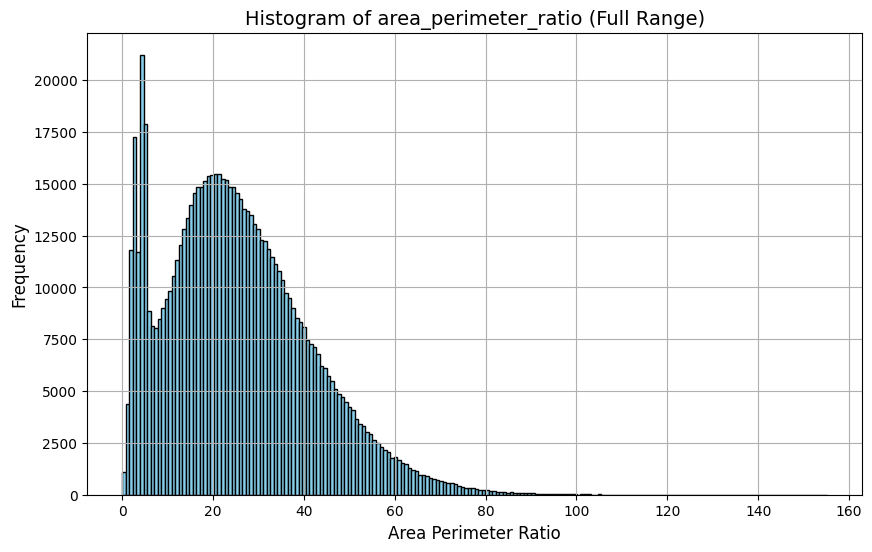

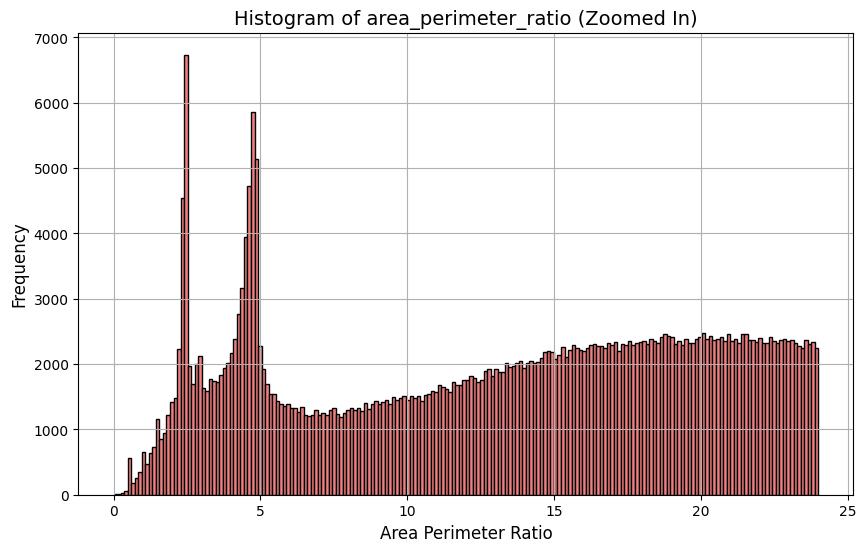

In [4]:
import matplotlib.pyplot as plt

def plot_area_perimeter_histogram(gdf, attribute):
    # Extract the attribute values
    attribute_values = gdf[attribute]
    
    # Plot the full histogram
    plt.figure(figsize=(10, 6))
    plt.hist(attribute_values, bins=200, color='skyblue', edgecolor='black')
    
    # Set plot labels and title for the full range
    plt.title(f'Histogram of {attribute} (Full Range)', fontsize=14)
    plt.xlabel(attribute.replace('_', ' ').title(), fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True)
    
    # Show the full plot
    plt.show()

    # Plot the zoomed-in histogram
    plt.figure(figsize=(10, 6))
    plt.hist(attribute_values, bins=200, range=(0, 24), color='lightcoral', edgecolor='black')
    
    # Set plot labels and title for the zoomed-in range
    plt.title(f'Histogram of {attribute} (Zoomed In)', fontsize=14)
    plt.xlabel(attribute.replace('_', ' ').title(), fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True)
    
    # Show the zoomed-in plot
    plt.show()

# Example usage with gdf and 'area_perimeter_ratio' as the attribute
plot_area_perimeter_histogram(gdf, 'area_perimeter_ratio')


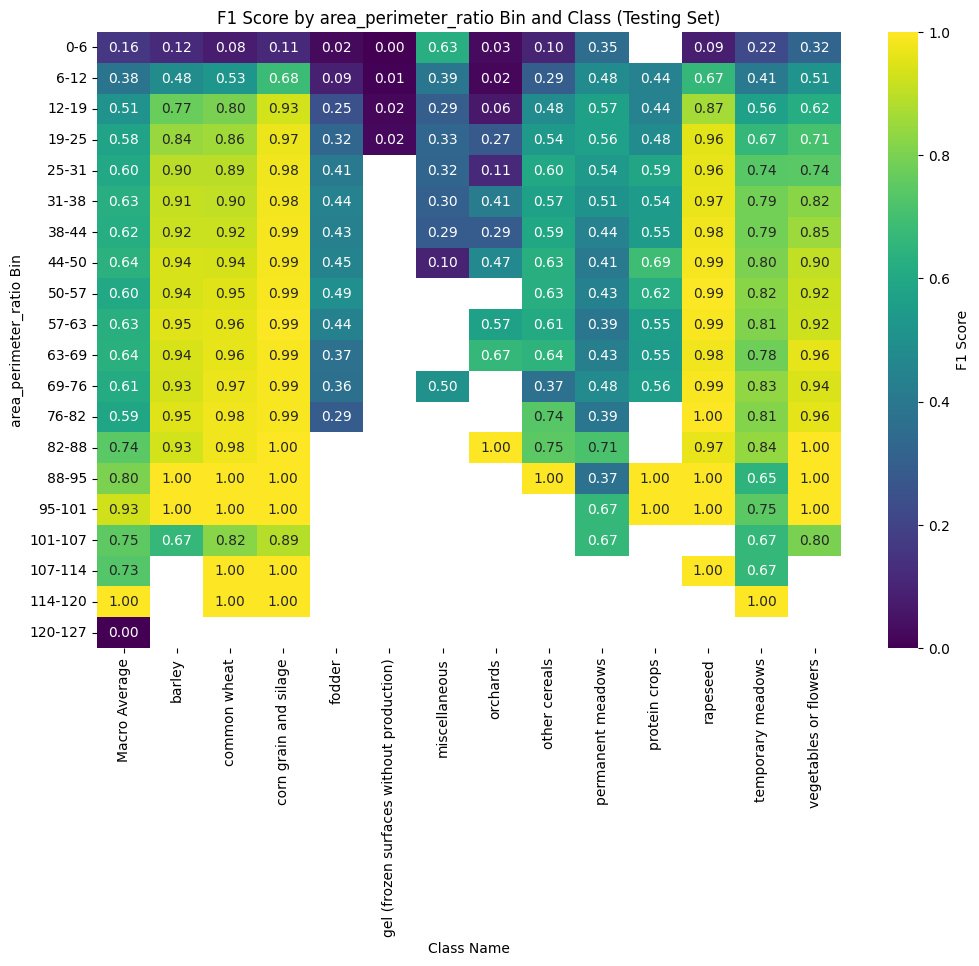

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

def plot_f1_heatmap_testing(gdf, attribute):
    # Filter the data to only the testing set
    testing_set = gdf[gdf['region'] == 'frh04']
    
    # Create a dictionary to map classid to classname
    classid_to_classname = dict(zip(gdf['True_Label'], gdf['classname']))
    
    unique_classes = np.unique(testing_set['True_Label'])
    
    def calculate_f1_scores(data, attribute, bins, unique_classes):
        results = []
        for i in range(len(bins)-1):
            bin_data = data[(data[attribute] >= bins[i]) & (data[attribute] < bins[i+1])]
            if bin_data.empty:
                continue  # Skip empty bins
            
            for class_id in unique_classes:
                TP = ((bin_data['Predicted_Label'] == class_id) & (bin_data['True_Label'] == class_id)).sum()
                FP = ((bin_data['Predicted_Label'] == class_id) & (bin_data['True_Label'] != class_id)).sum()
                FN = ((bin_data['Predicted_Label'] != class_id) & (bin_data['True_Label'] == class_id)).sum()

                # Calculate F1 score for this bin and class
                precision = TP / (TP + FP) if (TP + FP) > 0 else np.nan
                recall = TP / (TP + FN) if (TP + FN) > 0 else np.nan
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else np.nan

                # Round the bin ranges down to 0 decimals for readability
                bin_range = f'{np.floor(bins[i]):.0f}-{np.floor(bins[i+1]):.0f}'

                results.append({
                    'bin_range': bin_range,
                    'class': classid_to_classname.get(class_id, class_id),
                    'f1_score': f1
                })

            # Calculate global F1 score for the bin using scikit-learn
            if len(bin_data) > 0:
                global_f1 = f1_score(bin_data['True_Label'], bin_data['Predicted_Label'], average='macro', zero_division=0)
            else:
                global_f1 = np.nan

            # Add global F1 score to the results
            results.append({
                'bin_range': bin_range,
                'class': 'Macro Average',
                'f1_score': global_f1
            })

        return pd.DataFrame(results)
    
    # Define the number of bins
    min_value, max_value = testing_set[attribute].min(), testing_set[attribute].max()
    bins = np.linspace(min_value, max_value, 21)  # Creating 20 bins

    # Calculate F1 scores for the testing set
    testing_f1 = calculate_f1_scores(testing_set, attribute, bins, unique_classes)

    # Ensure bins are sorted numerically by their lower bound
    testing_f1['bin_range'] = pd.Categorical(testing_f1['bin_range'], categories=sorted(testing_f1['bin_range'].unique(), key=lambda x: float(x.split('-')[0])), ordered=True)

    # Pivot the DataFrame to prepare for heatmap plotting
    f1_pivot = testing_f1.pivot(index='bin_range', columns='class', values='f1_score')

    # Plot the F1 score heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(f1_pivot, annot=True, cmap='viridis', vmin=0, vmax=1, fmt='.2f', cbar_kws={'label': 'F1 Score'})
    plt.title(f'F1 Score by {attribute} Bin and Class (Testing Set)')
    plt.ylabel(f'{attribute} Bin')
    plt.xlabel('Class Name')
    plt.show()

# Example usage
plot_f1_heatmap_testing(gdf, 'area_perimeter_ratio')


/tmp/ipykernel_5890/2396902722.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='bin_range', y='f1_score', data=macro_f1, palette='viridis')


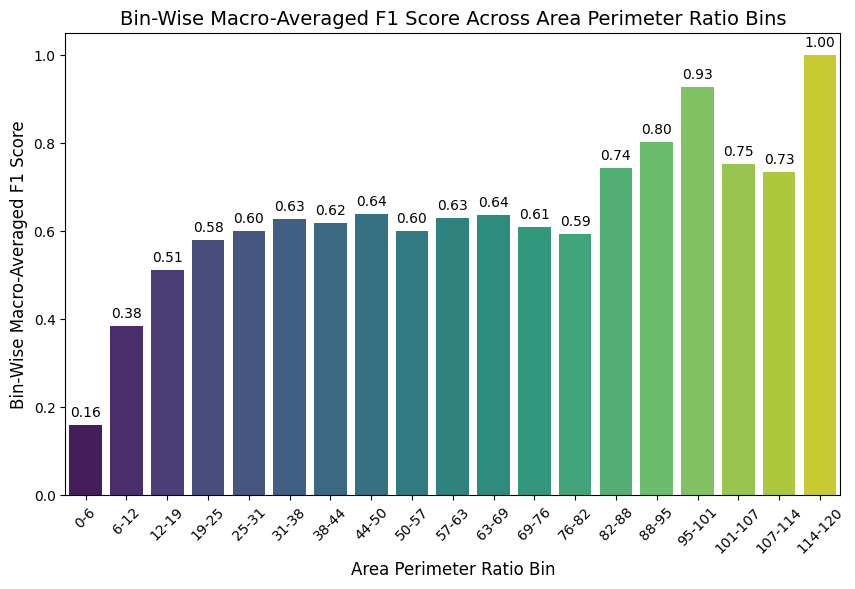

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

def plot_f1_heatmap_testing(gdf, attribute):
    # Filter the data to only the testing set
    testing_set = gdf[gdf['region'] == 'frh04']
    
    # Create a dictionary to map classid to classname
    classid_to_classname = dict(zip(gdf['True_Label'], gdf['classname']))
    
    unique_classes = np.unique(testing_set['True_Label'])
    
    def calculate_f1_scores(data, attribute, bins, unique_classes):
        results = []
        for i in range(len(bins)-1):
            bin_data = data[(data[attribute] >= bins[i]) & (data[attribute] < bins[i+1])]
            if bin_data.empty:
                continue  # Skip empty bins
            
            for class_id in unique_classes:
                TP = ((bin_data['Predicted_Label'] == class_id) & (bin_data['True_Label'] == class_id)).sum()
                FP = ((bin_data['Predicted_Label'] == class_id) & (bin_data['True_Label'] != class_id)).sum()
                FN = ((bin_data['Predicted_Label'] != class_id) & (bin_data['True_Label'] == class_id)).sum()

                # Calculate F1 score for this bin and class
                precision = TP / (TP + FP) if (TP + FP) > 0 else np.nan
                recall = TP / (TP + FN) if (TP + FN) > 0 else np.nan
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else np.nan

                # Round the bin ranges down to 0 decimals for readability
                bin_range = f'{np.floor(bins[i]):.0f}-{np.floor(bins[i+1]):.0f}'

                results.append({
                    'bin_range': bin_range,
                    'class': classid_to_classname.get(class_id, class_id),
                    'f1_score': f1
                })

            # Calculate global F1 score for the bin using scikit-learn
            if len(bin_data) > 0:
                global_f1 = f1_score(bin_data['True_Label'], bin_data['Predicted_Label'], average='macro', zero_division=0)
            else:
                global_f1 = np.nan

            # Add global F1 score for the bin
            results.append({
                'bin_range': bin_range,
                'class': 'Bin-Wise Macro-Averaged F1 Score',
                'f1_score': global_f1
            })

        return pd.DataFrame(results)
    
    # Define the number of bins
    min_value, max_value = testing_set[attribute].min(), testing_set[attribute].max()
    bins = np.linspace(min_value, max_value, 21)  # Creating 20 bins

    # Calculate F1 scores for the testing set
    testing_f1 = calculate_f1_scores(testing_set, attribute, bins, unique_classes)

    # Filter only the rows with the 'Bin-Wise Macro-Averaged F1 Score'
    macro_f1 = testing_f1[testing_f1['class'] == 'Bin-Wise Macro-Averaged F1 Score']

    # Exclude the last bin (last row) by using .iloc[:-1]
    macro_f1 = macro_f1.iloc[:-1]

    # Plot the Bin-Wise Macro-Averaged F1 Score
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='bin_range', y='f1_score', data=macro_f1, palette='viridis')
    
    # Add value labels on top of each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)

    # Set labels and title for the plot
    title_formatted = attribute.replace("_", " ").title()
    plt.title(f'Bin-Wise Macro-Averaged F1 Score Across {title_formatted} Bins', fontsize=14)
    plt.xlabel(f'{title_formatted} Bin', fontsize=12)
    plt.ylabel('Bin-Wise Macro-Averaged F1 Score', fontsize=12)
    plt.xticks(rotation=45)
    
    # Remove the grid
    ax.grid(False)
    
    # Save the plot as an SVG file and ensure all elements are captured
    plt.savefig('output_plot.svg', format='svg', bbox_inches='tight')
    
    # Show the plot
    plt.show()


plot_f1_heatmap_testing(gdf, 'area_perimeter_ratio')


/tmp/ipykernel_5890/1675349433.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Group', y='F1 Score', data=comparison_df, palette='viridis')


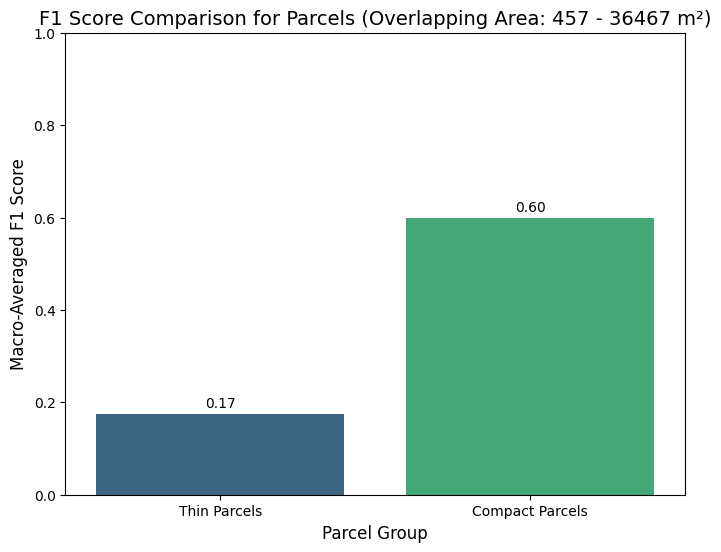

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

def compare_thin_and_compact_parcels_in_overlapping_range(gdf, thinness_threshold):
    # Step 1: Filter thin parcels based on area-to-perimeter ratio
    thin_parcels = gdf[gdf['area_perimeter_ratio'] <= thinness_threshold]
    
    # Step 2: Filter compact parcels based on area-to-perimeter ratio
    compact_parcels = gdf[gdf['area_perimeter_ratio'] > thinness_threshold]

    # Step 3: Find the minimum and maximum area for both groups
    min_area_thin = thin_parcels['area'].min()
    max_area_thin = thin_parcels['area'].max()
    min_area_compact = compact_parcels['area'].min()
    max_area_compact = compact_parcels['area'].max()

    # Step 4: Find the overlapping area range
    min_area_overlap = max(min_area_thin, min_area_compact)
    max_area_overlap = min(max_area_thin, max_area_compact)

    # Step 5: Filter thin and compact parcels to only include those within the overlapping area range
    thin_parcels_in_overlap = thin_parcels[(thin_parcels['area'] >= min_area_overlap) & (thin_parcels['area'] <= max_area_overlap)]
    compact_parcels_in_overlap = compact_parcels[(compact_parcels['area'] >= min_area_overlap) & (compact_parcels['area'] <= max_area_overlap)]

    # Function to calculate the macro-averaged F1 score
    def calculate_f1(data):
        if data.empty:
            return np.nan
        
        unique_classes = np.unique(data['True_Label'])
        all_f1_scores = []
        
        for class_id in unique_classes:
            TP = ((data['Predicted_Label'] == class_id) & (data['True_Label'] == class_id)).sum()
            FP = ((data['Predicted_Label'] == class_id) & (data['True_Label'] != class_id)).sum()
            FN = ((data['Predicted_Label'] != class_id) & (data['True_Label'] == class_id)).sum()

            precision = TP / (TP + FP) if (TP + FP) > 0 else np.nan
            recall = TP / (TP + FN) if (TP + FN) > 0 else np.nan
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else np.nan

            all_f1_scores.append(f1)

        # Return the macro-averaged F1 score
        return np.nanmean(all_f1_scores)

    # Step 6: Calculate F1 scores for both thin and compact parcels in the overlapping area range
    thin_f1 = calculate_f1(thin_parcels_in_overlap)
    compact_f1 = calculate_f1(compact_parcels_in_overlap)

    # Step 7: Create a DataFrame for plotting
    comparison_df = pd.DataFrame({
        'Group': ['Thin Parcels', 'Compact Parcels'],
        'F1 Score': [thin_f1, compact_f1]
    })

    # Step 8: Plot the F1 scores for thin and compact parcels
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x='Group', y='F1 Score', data=comparison_df, palette='viridis')
    plt.title(f'F1 Score Comparison for Parcels (Overlapping Area: {min_area_overlap:.0f} - {max_area_overlap:.0f} m²)', fontsize=14)
    plt.ylabel('Macro-Averaged F1 Score', fontsize=12)
    plt.xlabel('Parcel Group', fontsize=12)
    plt.ylim(0, 1)

    # Add the F1 score value on top of each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 8), textcoords='offset points', fontsize=10)

    # Display the plot
    plt.show()


compare_thin_and_compact_parcels_in_overlapping_range(gdf, thinness_threshold=6)


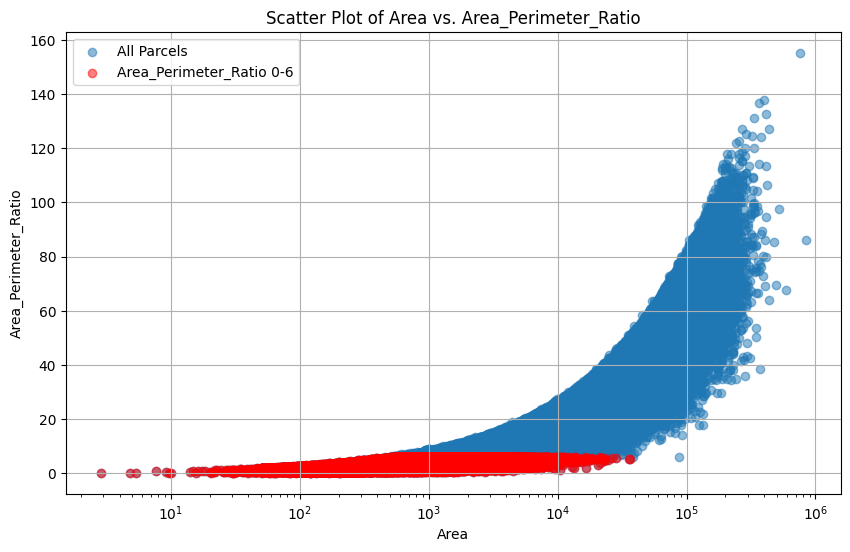

/tmp/ipykernel_1005/2265808985.py:22: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  filtered_gdf = gdf[gdf['area_perimeter_ratio'].between(0, 6, inclusive=True)]
/tmp/ipykernel_1005/2265808985.py:27: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  outside_filtered_gdf = gdf[~gdf['area_perimeter_ratio'].between(0, 6, inclusive=True)]


Summary Statistics for parcels with Area_Perimeter_Ratio 0-6:
count    91258.000000
mean      1379.990803
std       1375.334033
min          2.878831
25%        508.082115
50%        970.237940
75%       1792.486575
max      36467.453362
Name: area, dtype: float64

Summary Statistics for parcels outside of Area_Perimeter_Ratio 0-6:
count    672539.000000
mean      23755.492253
std       24982.656870
min         456.642032
25%        7484.695515
50%       15703.736970
75%       31103.526323
max      839716.229376
Name: area, dtype: float64


In [48]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np


# Scatter plot of area vs. area_perimeter_ratio for all parcels
plt.figure(figsize=(10, 6))
plt.scatter(gdf['area'], gdf['area_perimeter_ratio'], alpha=0.5, label='All Parcels')
plt.scatter(gdf[gdf['area_perimeter_ratio'].between(0, 6, inclusive='both')]['area'], 
            gdf[gdf['area_perimeter_ratio'].between(0, 6, inclusive='both')]['area_perimeter_ratio'], 
            color='red', alpha=0.5, label='Area_Perimeter_Ratio 0-6')
plt.xlabel('Area')
plt.ylabel('Area_Perimeter_Ratio')
plt.title('Scatter Plot of Area vs. Area_Perimeter_Ratio')
plt.legend()
plt.xscale('log')  # Use logarithmic scale for better visualization of wide area range
plt.yscale('linear')
plt.grid(True)
plt.show()

# Summary statistics for parcels with area_perimeter_ratio in 0-6
filtered_gdf = gdf[gdf['area_perimeter_ratio'].between(0, 6, inclusive=True)]
print("Summary Statistics for parcels with Area_Perimeter_Ratio 0-6:")
print(filtered_gdf['area'].describe())

# Summary statistics for parcels outside of area_perimeter_ratio 0-6
outside_filtered_gdf = gdf[~gdf['area_perimeter_ratio'].between(0, 6, inclusive=True)]
print("\nSummary Statistics for parcels outside of Area_Perimeter_Ratio 0-6:")
print(outside_filtered_gdf['area'].describe())



In [100]:
import pandas as pd

def calculate_thin_sample_proportion(gdf, ratio_threshold=6, output_csv_path='thin_sample_proportion.csv'):
    # Step 1: Calculate the total number of samples, grouped by class name
    total_samples = gdf.groupby('classname').size().reset_index(name='Total Samples')

    # Step 2: Filter the samples with area-to-perimeter ratio ≤ ratio_threshold (within 0-6)
    thin_samples = gdf[gdf['area_perimeter_ratio'] <= ratio_threshold]

    # Step 3: Calculate the number of thin samples, grouped by class name
    thin_sample_counts = thin_samples.groupby('classname').size().reset_index(name='Thin Samples')

    # Step 4: Merge the total and thin sample counts
    result = pd.merge(total_samples, thin_sample_counts, on='classname', how='left')

    # Fill NaN values in Thin Samples (for classes with no thin samples) with 0
    result['Thin Samples'].fillna(0, inplace=True)

    # Convert Thin Samples to integer
    result['Thin Samples'] = result['Thin Samples'].astype(int)

    # Step 5: Calculate the percentage of thin samples
    result['% Thin Samples'] = (result['Thin Samples'] / result['Total Samples']) * 100

    # Step 6: Add a new column 'Total Samples Without Thin Samples'
    result['Total Samples Without Thin Samples'] = result['Total Samples'] - result['Thin Samples']

    # Step 7: Add a row for the total number of samples across all classes
    total_row = pd.DataFrame({
        'classname': ['Total'],
        'Total Samples': [result['Total Samples'].sum()],
        'Thin Samples': [result['Thin Samples'].sum()],
        '% Thin Samples': [(result['Thin Samples'].sum() / result['Total Samples'].sum()) * 100],
        'Total Samples Without Thin Samples': [result['Total Samples Without Thin Samples'].sum()]
    })

    # Append the total row to the result table
    result = pd.concat([result, total_row], ignore_index=True)

    # Output the table as a CSV file
    result.to_csv(output_csv_path, index=False)

    # Display the table
    print(result)
    print(f"CSV file saved at: {output_csv_path}")

calculate_thin_sample_proportion(gdf, ratio_threshold=6, output_csv_path='thin_sample_proportion.csv')


                                   classname  Total Samples  Thin Samples  \
0                                     barley          36905           171   
1                               common wheat          89555           348   
2                      corn grain and silage         153908           736   
3                                     fodder          23023           399   
4   gel (frozen surfaces without production)          12157          3457   
5                              miscellaneous          66550         49290   
6                                   orchards           3070           497   
7                              other cereals          20236           149   
8                          permanent meadows         127813         16772   
9                              protein crops           3302            28   
10                                  rapeseed          14732            56   
11                         temporary meadows         182212         17522   